## Assignment 1
### Stochastic Simulation

Team:
- Yuxin
- Marcel
- Koen

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sympy import isprime
from scipy.stats.qmc import LatinHypercube

## 1. Implement Sampling Techniques

Define the function that let's us randomly sample in three different ways:
- Pure Random Sampling
- Latin Hypercube Sampling
- Orthogonal Sampling

In [4]:
# Define the random sampling function
def random_sample(n, x_range=(0,10), y_range=(0,10), sampler='pure_random_sampling'):
    if sampler == 'pure_random_sampling':
        # Pure random sampling
        x_coords = np.random.uniform(x_range[0], x_range[1], n)
        y_coords = np.random.uniform(y_range[0], y_range[1], n)
        points = np.stack((x_coords, y_coords), axis=-1)

    elif sampler == 'latin_hypercube_sampling':
        # Latin Hypercube Sampling
        lhc = qmc.LatinHypercube(d=2)
        points = lhc.random(n)
        points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
        points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]

    elif sampler == 'orthogonal_sampling':
        # Orthogonal Sampling: Ensure n is a square of a prime number
        sqrt_n = int(np.sqrt(n))
        if sqrt_n**2 != n or not isprime(sqrt_n):
            raise ValueError("n must be the square of a prime number for orthogonal sampling.")
        
        # Create a regular grid
        x_coords = np.linspace(x_range[0], x_range[1], sqrt_n)
        y_coords = np.linspace(y_range[0], y_range[1], sqrt_n)
        
        # Create all combinations of x and y coordinates
        xv, yv = np.meshgrid(x_coords, y_coords)
        points = np.column_stack([xv.ravel(), yv.ravel()])


    else:
        raise ValueError("Invalid sampler specified.")
    
    return points


In [5]:
# Define Mandelbrot set calculation function
def mandelbrot(point, max_iter=1000):
    z = 0
    for i in range(max_iter):
        z = z**2 + point
        if abs(z) > 2:
            return i
    return max_iter


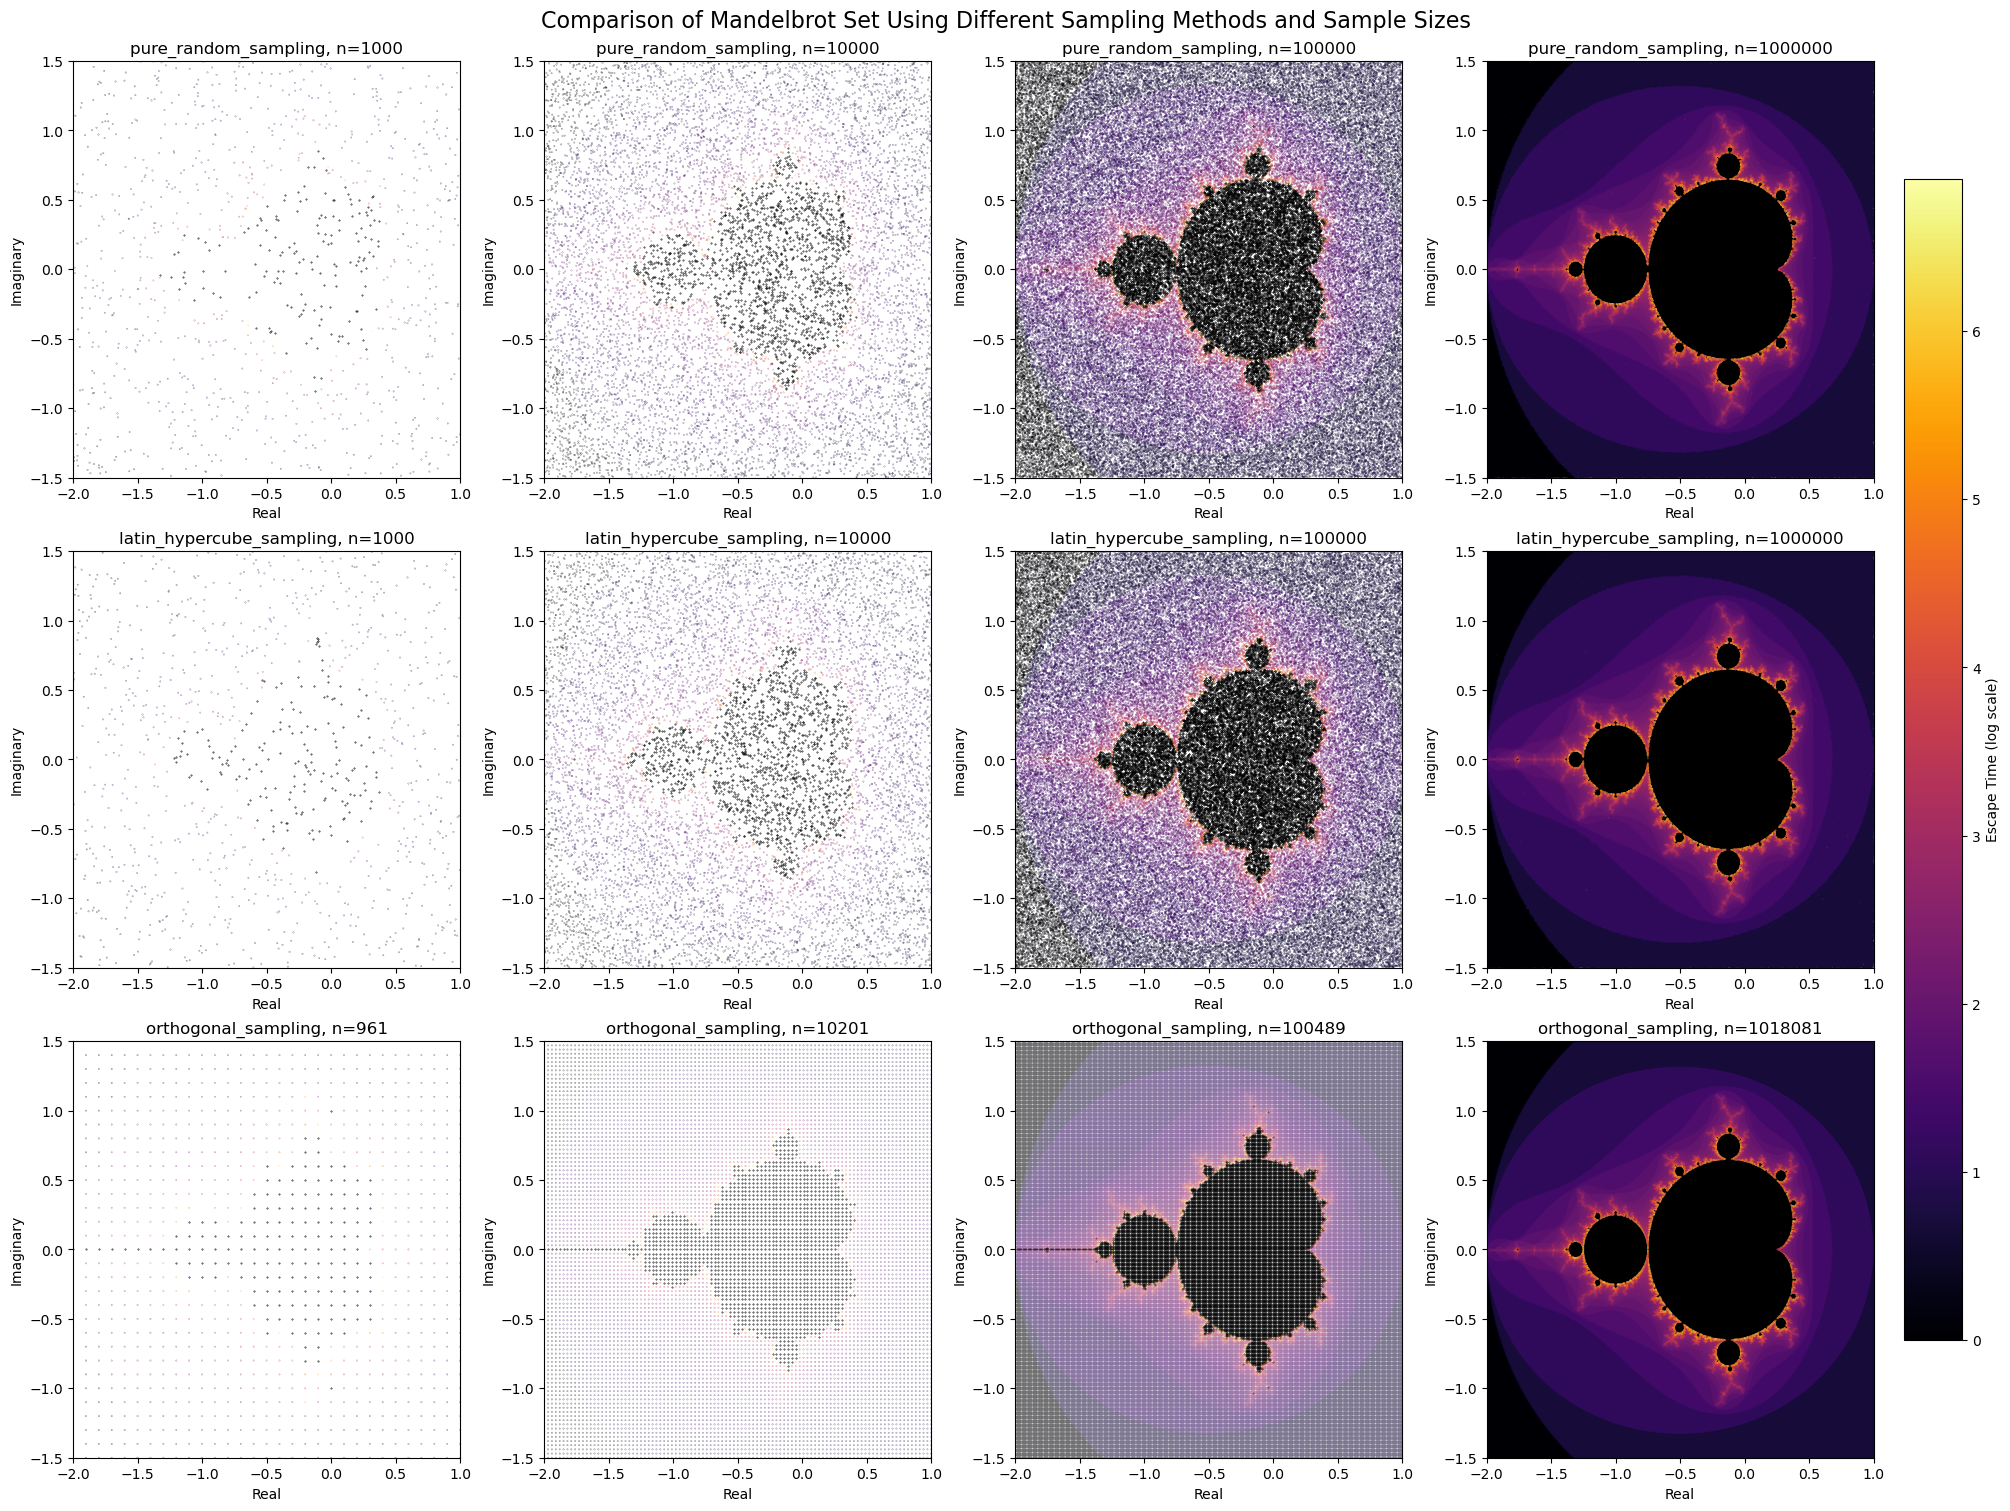

In [6]:
# Define the Mandelbrot plotting function
def plot_mandelbrot(n=10000, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler='pure_random_sampling', ax=None):
    points = random_sample(n, x_range, y_range, sampler)
    complex_points = points[:, 0] + 1j * points[:, 1]
    iterations = np.array([mandelbrot(point, max_iter) for point in complex_points])

    # Separate points inside and outside the Mandelbrot set
    in_set = iterations == max_iter
    outside_set = ~in_set

    # Use log-scaled colors for points outside the set
    colors = np.log(iterations + 1)

    # Plot on the provided axis
    ax.scatter(complex_points[in_set].real, complex_points[in_set].imag, color='black', s=0.5, marker='.')
    scatter = ax.scatter(complex_points[outside_set].real, complex_points[outside_set].imag,
                         c=colors[outside_set], cmap='inferno', s=0.1, marker='.')

    # Set plot details
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(f"{sampler}, n={n}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    return scatter

# Set up the subplots for comparing different sampling methods and sample sizes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
fig.suptitle("Comparison of Mandelbrot Set Using Different Sampling Methods and Sample Sizes", fontsize=16)

# Define parameters
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
sample_sizes = [1000, 10000, 100000, 1000000]
orthogonal_sample_sizes = [961, 10201, 100489, 1018081]  # Only for orthogonal sampling

# Plot for each sampler and sample size
for row, sampler in enumerate(samplers):
    for col, n in enumerate(sample_sizes if sampler != 'orthogonal_sampling' else orthogonal_sample_sizes):
        ax = axes[row, col]
        scatter = plot_mandelbrot(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler=sampler, ax=ax)

# Add a color bar to the last axis for escaping points
fig.colorbar(scatter, ax=axes[:, -1], orientation='vertical', label="Escape Time (log scale)")

plt.show()

---
## 2. Monte Carlo Integration

Estimate the area ( $A_M$ ) of the Mandelbrot set using Monte Carlo integration.
- Define a monte_carlo_area( ) function
- Accept sampling points and determine if each point belongs to the Mandelbrot set using iteration limits
- Calculate the area based on the proportion of points within the Mandelbrot set

In [31]:
# Pure Random Sampling
def estimate_area_random(n_samples, x_min=-2, x_max=2, y_min=-2, y_max=2):
    samples_in_set = 0
    for _ in range(n_samples):
        x, y = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
        c = complex(x, y)
        if mandelbrot(c):
            samples_in_set += 1
    area = (samples_in_set / n_samples) * (x_max - x_min) * (y_max - y_min)
    return area

# Latin Hypercube Sampling
def estimate_area_latin_hypercube(n_samples, x_min=-2, x_max=2, y_min=-2, y_max=2):
    # Generate Latin Hypercube samples
    lhs_sampler = LatinHypercube(d=2)
    lhs_samples = lhs_sampler.random(n_samples)
    # Scale to the desired range
    lhs_samples[:, 0] = lhs_samples[:, 0] * (x_max - x_min) + x_min
    lhs_samples[:, 1] = lhs_samples[:, 1] * (y_max - y_min) + y_min
    samples_in_set = 0
    for x, y in lhs_samples:
        c = complex(x, y)
        # Check if the point is in the Mandelbrot set
        if mandelbrot(c):
            samples_in_set += 1
    area = (samples_in_set / n_samples) * (x_max - x_min) * (y_max - y_min)
    return area

# Orthogonal Sampling
def estimate_area_orthogonal(n_samples_per_axis, x_min=-2, x_max=2, y_min=-2, y_max=2):
    samples_in_set = 0
    dx = (x_max - x_min) / n_samples_per_axis
    dy = (y_max - y_min) / n_samples_per_axis
    for i in range(n_samples_per_axis):
        for j in range(n_samples_per_axis):
            x = x_min + (i + np.random.rand()) * dx
            y = y_min + (j + np.random.rand()) * dy
            c = complex(x, y)
            if mandelbrot(c):
                samples_in_set += 1
    area = (samples_in_set / (n_samples_per_axis**2)) * (x_max - x_min) * (y_max - y_min)
    return area

In [33]:
# Calculate the area as n = 10000
area_random = estimate_area_random(10000)
print("Estimated area using Pure Random Sampling:", area_random)

area_lhs = estimate_area_latin_hypercube(10000)
print("Estimated area using Latin Hypercube Sampling:", area_lhs)

area_orthogonal = estimate_area_orthogonal(101)
print("Estimated area using Orthogonal Sampling:", area_orthogonal)

Estimated area using Pure Random Sampling: 12.6928
Estimated area using Latin Hypercube Sampling: 12.6432
Estimated area using Orthogonal Sampling: 12.568179590236252


---
## 3. Convergence Investigation

Test the convergence of area estimates by adjusting sample sizes and iteration counts.
- Run monte_carlo_area( ) with increasing sample sizes and iterations for each sampling method
- Track area estimates $A_{j,s}$ for all $j < i$
- Calculate and plot $(A_{j,s} - A_{i,s})$ to observe convergence behavior

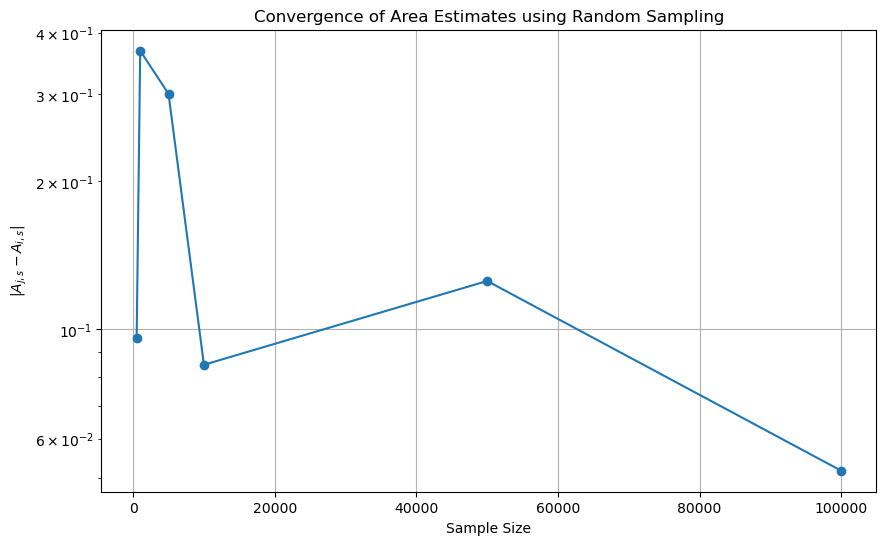

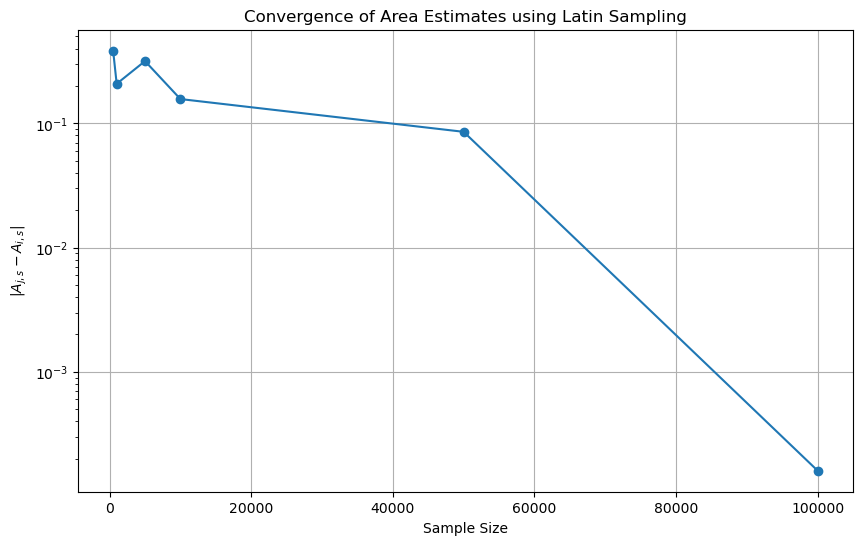

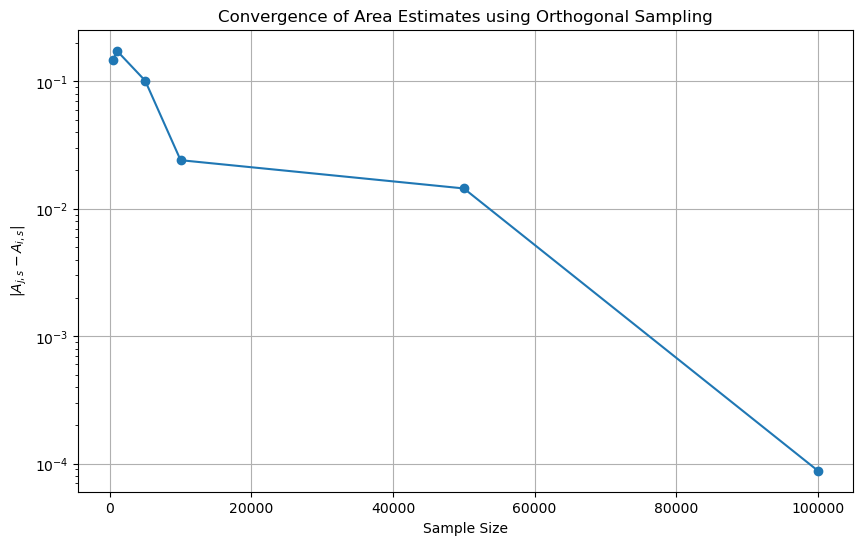

In [70]:
# Placeholder function for monte_carlo_area
# Replace with the actual function that calculates area estimates using a sampling method
def monte_carlo_area(n_samples, max_iter=1000, method="random"):
    if method == "random":
        return estimate_area_random(n_samples)
    elif method == "latin":
        return estimate_area_latin_hypercube(n_samples)
    elif method == "orthogonal":
        return estimate_area_orthogonal(int(np.sqrt(n_samples)))
    else:
        raise ValueError("Unknown method")

# Convergence Investigation
def convergence_investigation(sample_sizes, max_iter=1000, method="random"):
    area_estimates = []
    for n_samples in sample_sizes:
        area = monte_carlo_area(n_samples, max_iter=max_iter, method=method)
        area_estimates.append(area)

    # Calculate successive differences (A_{j,s} - A_{i,s})
    convergence_diffs = [abs(area_estimates[j] - area_estimates[j-1]) for j in range(1, len(area_estimates))]
    
    # Plotting the convergence behavior
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes[1:], convergence_diffs, marker='o', linestyle='-')
    plt.xlabel("Sample Size")
    plt.ylabel(r"$|A_{j,s} - A_{i,s}|$")
    plt.title(f"Convergence of Area Estimates using {method.capitalize()} Sampling")
    plt.yscale("log")  # Log scale can help visualize convergence
    plt.grid(True)
    plt.show()

# Convergence of increasing sample sizes
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
convergence_investigation(sample_sizes, max_iter=1000, method="random")
convergence_investigation(sample_sizes, max_iter=1000, method="latin")
convergence_investigation(sample_sizes, max_iter=1000, method="orthogonal")

Reference Area (A_ref) with 1000000 samples: 12.56264
Method: random, Samples: 100, Estimated Area: 13.12, Error: 0.044366470741818535
Method: random, Samples: 500, Estimated Area: 12.352, Error: 0.01676717632599515
Method: random, Samples: 1000, Estimated Area: 12.4, Error: 0.012946323384256787
Method: random, Samples: 5000, Estimated Area: 12.4768, Error: 0.006832958677475375
Method: random, Samples: 10000, Estimated Area: 12.6432, Error: 0.00641266485388423
Method: random, Samples: 50000, Estimated Area: 12.53184, Error: 0.0024517139709487237
Method: random, Samples: 100000, Estimated Area: 12.58672, Error: 0.0019167945591053836
Method: latin, Samples: 100, Estimated Area: 12.64, Error: 0.0061579413244350345
Method: latin, Samples: 500, Estimated Area: 12.64, Error: 0.0061579413244350345
Method: latin, Samples: 1000, Estimated Area: 12.576, Error: 0.0010634707354505487
Method: latin, Samples: 5000, Estimated Area: 12.5888, Error: 0.002082364853247474
Method: latin, Samples: 10000, E

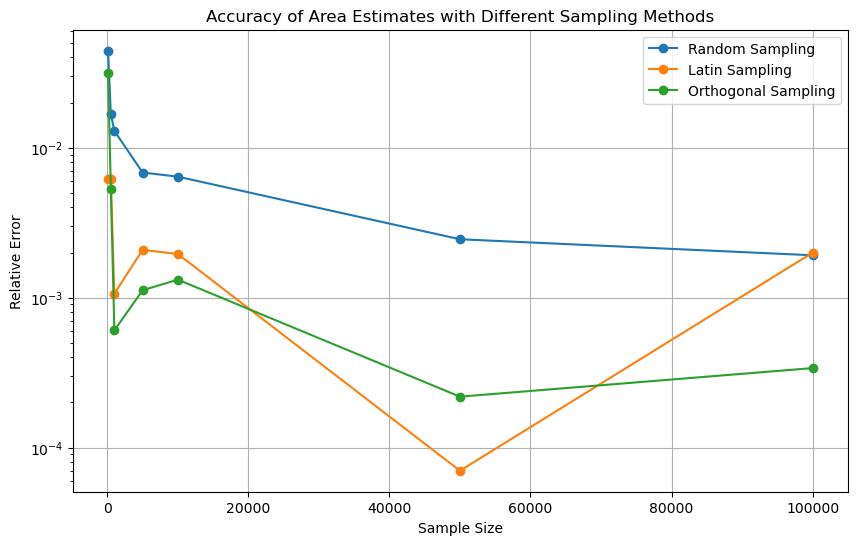

In [72]:
# Calculate a Reference Area
reference_samples = 1000000  # High number of samples for reference
A_ref = monte_carlo_area(reference_samples, max_iter=1000, method="random")  # Choose one method for reference
print(f"Reference Area (A_ref) with {reference_samples} samples: {A_ref}")

# Estimate Area for Each Sampling Method with Various Sample Sizes
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
methods = ["random", "latin", "orthogonal"]
errors = {method: [] for method in methods}

for method in methods:
    for n_samples in sample_sizes:
        A_estimate = monte_carlo_area(n_samples, max_iter=1000, method=method)
        error = abs(A_estimate - A_ref) / A_ref  # Relative error
        errors[method].append(error)
        print(f"Method: {method}, Samples: {n_samples}, Estimated Area: {A_estimate}, Error: {error}")

# Plot the Errors for Each Sampling Method
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(sample_sizes, errors[method], marker='o', label=f"{method.capitalize()} Sampling")
    
plt.xlabel("Sample Size")
plt.ylabel("Relative Error")
plt.yscale("log")  # Log scale to better visualize error decrease
plt.title("Accuracy of Area Estimates with Different Sampling Methods")
plt.legend()
plt.grid(True)
plt.show()